# Step 1: Data Processing

## 1.1 Load Dataset 

This function saves the midi file location so that we can easily analyze and extract information form them later on during Data Exploration

In [45]:
import os
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt

def load_midi_locations(base_dir):
    """
    Loads the MIDI file locations from the specified base directory.
    
    Args:
        base_dir (str): The base directory path.
        
    Returns:
        list: A list of lists, where each inner list contains the file paths for a composer.
    """
    
    # Initializing a list to store file locations
    file_names = []
    
    # Iterate over each folder in the specified directory
    for composer_folder in os.listdir(base_dir):
        # Check if the folder name starts with a dot (hidden folder)
        if not composer_folder.startswith('.'):
            # Construct the full path to the composer folder
            composer_path = os.path.join(base_dir, composer_folder)
            
            # Initialize a temporary list to store file paths for the current composer
            tmp = []
            
            # Iterate over each file in the composer folder
            for file_name in os.listdir(composer_path):
                # Construct the full path to the file and append it to the temporary list
                file_path = os.path.join(composer_path, file_name)
                tmp.append(file_path)
            
            # Append the list of file paths for the current composer to the main list
            file_names.append(tmp)
    
    return file_names

In [46]:
file_paths = load_midi_locations("Datasets/PS1")

## 1.2 Exploratory Data Analysis

For the EDA we will focus on some of the features which help us analyze the rhythmic patterns through note-based features, tempo and more. The features which we will be focusing on are the following

1. **Note-Based Features**:

   - **Pitch**: Is a collection of pitches of it's coresponding notes.

   - **Melodic Intervals**: Calculate the distribution of melodic intervals (differences in pitch between consecutive notes). It reflects melodic 
   patterns and contour.
   
   - **Note Densities**: Determine the average number of notes per unit of time. It indicates the level of musical activity or density.
   

2. **Timing and Tempo Features**:

   - **Inter-Onset Intervals**: Calculate the time differences between consecutive note onsets. It represents the rhythmic patterns and tempo fluctuations.
3. **Melodic and Rhythmic Patterns**:

   - **N-grams**: Extract melodic or rhythmic patterns using n-grams. They represent recurring sequences of notes or rhythms.

   - **Motif Analysis**: Identify specific motifs or musical themes within the composition. It captures distinctive melodic or rhythmic patterns associated with a composer's style.


4. **Structural Features**:

   - **Section Analysis**: Divide the composition into sections (e.g., intro, verse, chorus) and analyze their durations, patterns, or transitions.
   
   - **Repetition Analysis**: Identify repeated musical sections or patterns. It captures structural and compositional elements.

In [59]:
# This is a sample MIDI file which has been loaded to perform Data exploration
midi_data = pretty_midi.PrettyMIDI(file_paths[0][14])

### 1. Pitch 

Pitch feature is very usefull for classification and identification of composers as it provides information about the tonal and harmonic content of the music, which is often distinctive across different composers. It's values and their relationships can also capture melodic patterns and tonal characteristics that contribute to a composer's style.

In [109]:
def extract_pitch(midi_data):
    # Initalizing lists 
    pitches = []
    
    # Extracting pitch, velocity and note duration features
    for instrument in midi_data.instruments:
        
        # Loop through each note and add to the lists 
        for note in instrument.notes:
            pitches.append(note.pitch)
    
    return pitches

In the visualization below we take a sample MIDI file to perform analysis upon

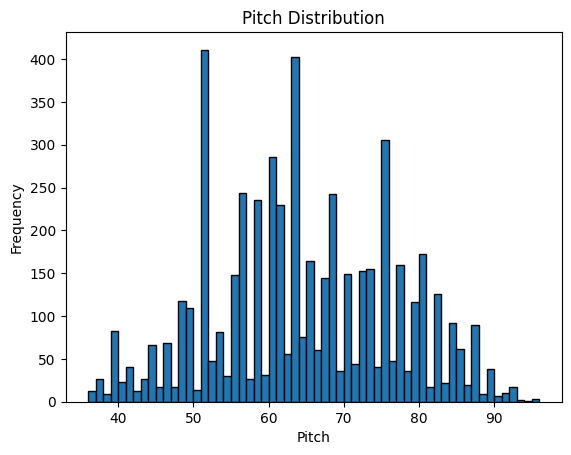

In [110]:
# Extract the pitches from the MIDI data
pitches = extract_pitch(midi_data)

# Create a histogram plot
plt.hist(pitches, bins=range(min(pitches), max(pitches) + 1), edgecolor='black')
plt.xlabel('Pitch')
plt.ylabel('Frequency')
plt.title('Pitch Distribution')
plt.show()

### 2. Melodic Intervals

Calculates the distribution of melodic intervals (differences in pitch between consecutive notes). It reflects melodic patterns and contour.

In [112]:
def extract_melodic_intervals(pitch_array):
    intervals = []
    
    for note1, note2 in zip(pitch_array[:-1], pitch_array[1:]):
        interval = note2 - note1
        intervals.append(interval)
    
    return intervals

Below we visualize the previously analyzed MIDI sample

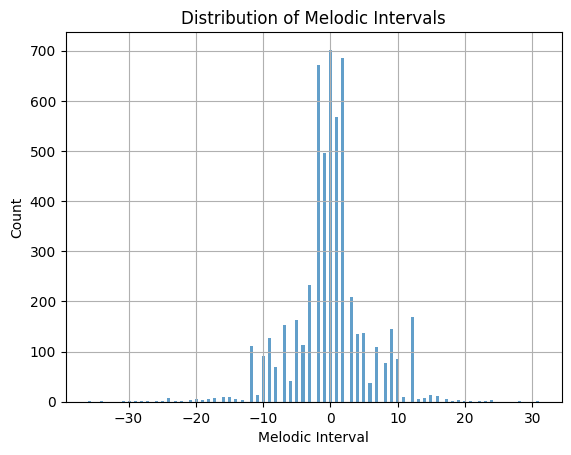

In [113]:
intervals = extract_melodic_intervals(pitches)
    
plt.hist(intervals, bins='auto', alpha=0.7)
plt.xlabel('Melodic Interval')
plt.ylabel('Count')
plt.title('Distribution of Melodic Intervals')
plt.grid(True)
plt.show()

### 3. Note Densities

Determine the average number of notes per unit of time. It indicates the label of musical activity or density

In [114]:
def extract_note_densities(midi_data):
    time_window = 2.0  # Time window in seconds
    note_densities = []
    current_time = 0.0
    
    while current_time < midi_data.get_end_time():
        notes_in_window = []
        
        for instrument in midi_data.instruments:
            notes_in_window.extend(instrument.notes)
        
        notes_in_window = [note for note in notes_in_window if note.start >= current_time and note.start < current_time + time_window]
        note_density = len(notes_in_window) / time_window
        note_densities.append(note_density)
        current_time += time_window
    
    return note_densities

### 4. Inter-Onset Intervals

 Calculates the time differences between consecutive note onsets. It represents the rhythmic patterns and tempo fluctuations.

In [115]:
def extract_inter_onset_intervals(midi_data):
    iois = []
    prev_onset = 0
    
    for instrument in midi_data.instruments:
        
        sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
        
        for note in sorted_notes:
            ioi = note.start - prev_onset
            iois.append(ioi)
            prev_onset = note.start
    
    return iois

Inter Onset Intervals:   -958.8640036250001


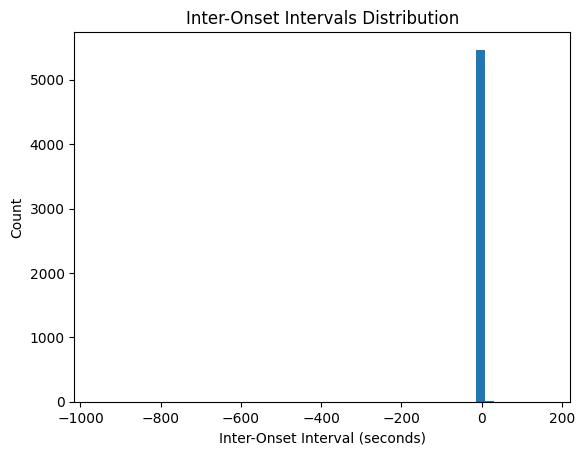

In [116]:
npiois = extract_inter_onset_intervals(midi_data)
print("Inter Onset Intervals:  ", np.min(npiois))

# Visualize inter-onset intervals
plt.hist(npiois, bins=50)
plt.xlabel('Inter-Onset Interval (seconds)')
plt.ylabel('Count')
plt.title('Inter-Onset Intervals Distribution')
plt.show()

## 1.3 Feature Extraction

The **extract_features** function takes a base directory as input and extracts various musical features from MIDI files found in that directory. 

These features include pitch, melodic intervals, note densities, and inter-onset intervals. 

The function assigns labels to the composers based on the filenames of the MIDI files and returns the extracted features as a padded numpy array, along with the corresponding composer labels.

The Image Below summarizes the Structure of the Data :

<img src="Doc_images/midiData.png" alt="Alternative text" width="35%" height="35%" />

In [126]:
def extract_features(base_dir):
    """
    Extracts features from MIDI files in the specified directory.
    
    Args:
        base_dir (str): The base directory containing the MIDI files.
    
    Returns:
        X (numpy.ndarray): The extracted features, padded to have equal length.
        y (numpy.ndarray): The corresponding labels for the composers.
    """
    
    X = []
    y = []    
    max_length = 0  # Variable to store the maximum length of features
    
    # Loading the file locations of all MIDI data
    file_pathways = load_midi_locations(base_dir)
    
    # Creating a dictionary to label the composers
    composer_label = {'Bach': 0, 'Beethoven': 1, 'Brahms': 2, 'Schubert': 3}
    
    for composers in file_pathways:
        
        for composer_files in composers:

            try: 
                midi_data = pretty_midi.PrettyMIDI(composer_files)
                
                # Extracting different features from MIDI data
                pitch = extract_pitch(midi_data)
                melodic_interval = extract_melodic_intervals(pitch)
                note_densities = extract_note_densities(midi_data)
                inter_onset_interval = extract_inter_onset_intervals(midi_data)
                
                features = [pitch, melodic_interval, note_densities, inter_onset_interval]
                
                # Update the maximum length if needed
                for feature in features:
                    max_length = max(max_length, len(feature))
                
                X.append(features)
                
                # Assigning labels based on composer names
                if "Beethoven" in composer_files: 
                    y.append(composer_label["Beethoven"])
                elif "Brahms" in composer_files: 
                    y.append(composer_label["Brahms"])
                elif "Bach" in composer_files: 
                    y.append(composer_label["Bach"])
                elif "Schubert" in composer_files: 
                    y.append(composer_label["Schubert"])
            except Exception as e:
                print(f"Error Processing {composer_files}: {str(e)}")
                continue
    
    X_padded = []
    for features in X:
        # Pad features to have equal length
        padded_features = [np.pad(f, (0, max_length - len(f)), mode='constant') for f in features]
        X_padded.append(padded_features)
    
    return np.array(X_padded), np.array(y)


In [127]:
X, y = extract_features("Datasets/PS1")

/Users/ibrahimbukhari/Documents/CodingProjects/MidiAnalysis/MidiAnalysis/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error Processing Datasets/PS1/Bach/WTK I, No. 14: Prelude and Fugue in F-sharp minor_BWV859_2305_prelude14.mid: no MTrk header at start of track


## 1.4 Splitting the Data into Train Test

In this part we will split the extracted features data structures into training and testing portions. This is to train our Machine Learning Algorithm

In [148]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Model Training

## 2.1 Training our Model

For classifying the composers we will use the Random Forest Classifier.

The '**train_model**' function trains the Random Forest Classifier by feeding it with a flattened version of the Data

**Parameters**: X_train, a list of the data we will use in training the data <br/>
                y_train, a list of labels for the classifier

**Output**: A trained Random Forest Classifier Model 

In [149]:
from sklearn.ensemble import RandomForestClassifier

def train_model(X_train, y_train):

    # Flatten the padded features for training
    X_train_flat = np.array([np.concatenate(x) for x in X_train])

    # Train a random forest classifier
    model = RandomForestClassifier()
    model.fit(X_train_flat, y_train)

    return model

## 2.2 Evaluating our Model

In '**evaluate_model**' function we will use the rest of our '*X_test*' data to make a prediction with our model and then evaluate our predictions with the orginal answers. We will then return our evaluation result

**Parameters**: *model*, trained random forest model<br/>
                *X_test*, the data we split for the test portion<br/>
                *y_test*, the orignal labels to the X_test data<br/>

**Output**: *accuracy*, a numerical value between 0 and 1 indicating our accuracy 

In [133]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, X_test, y_test):

    # Flatten the padded features for testing
    X_test_flat = np.array([np.concatenate(x) for x in X_test])

    # Make predictions on the test set
    y_pred = model.predict(X_test_flat)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

## 2.3 Putting it all together

In [ ]:
# Train the model
model = train_model(X_train, y_train)

# Evaluate the model
print("Random Forest Classifier Model Accuracy :    ",evaluate_model(model, X_test, y_test))

**Comment**

-> Review Dtaa training strategy

-> compare with other methods

-> add additional metric for evaluation random forest

-> research other classification algorithms



**Important**

-> we have explored midi library to extract important informatinon and insights which otherwise owuld not have been known

# Step 3: Classify using Model

## 3.1 Preprocessing the Midi file input

In [147]:
def preprocess_midi_file(composer_file):
    X = []
    max_length = 0  # Variable to store the maximum length of features

    try: 
        midi_data = pretty_midi.PrettyMIDI(composer_file)
                
        # Extracting different features from MIDI data
        pitch = extract_pitch(midi_data)
        melodic_interval = extract_melodic_intervals(pitch)
        note_densities = extract_note_densities(midi_data)
        inter_onset_interval = extract_inter_onset_intervals(midi_data)
                
        features = [pitch, melodic_interval, note_densities, inter_onset_interval]
                
        # Update the maximum length if needed
        for feature in features:
            max_length = max(max_length, len(feature))
                
        X.append(features)
                
    except Exception as e:
        print(f"Error Processing {composer_file}: {str(e)}")
    
    X_padded = []
    for features in X:
        # Pad features to have equal length
        padded_features = [np.pad(f, (0, max_length - len(f)), mode='constant') for f in features]
        X_padded.append(padded_features)
    
    return np.array(X_padded), np.array(y)

In [161]:
def classify_audio(model, midi_file):
    # Pre-process the data
    features = preprocess_midi_file(midi_file)

    # Making a prediction using the trained model
    composer_index = model.predict(features)[0]

    composer_label = {0:'Bach', 1:'Beethoven', 2:'Brahms', 3:'Schubert'}    
    composer = composer_label.get(composer_index, 'Unknown')

    return composer


In [ ]:
entriesps2 = os.listdir('Datasets/PS2')

trained_model = model

for ent in entriesps2:
    file_name_ps2 = "Datasets/PS2/"+ent
    composer = classify_audio(trained_model, file_name_ps2)
    print(f"Composer is {composer}")